<font color="magenta"> Sri : **OVERVIEW OF THE ASSIGNMENT**

<font color="magenta">**Objective**: Create a deep learning model that can detect the species of the birds from an image.

<font color="magenta">**Data Description** : The data set is sourced from Kaggle : https://www.kaggle.com/gpiosenka/100-bird-species
It is a collection of 230 bird species with 32,035 training images, 1,150 test images and 1150 validation images.
The images are 224 X 224 X 3 size and in jpg color format.
The data is already divided into test, train and validation data and there is also consolidated folder with all of the images in one. For my asssignment, I used the pre-divided test, train and validation data and used the consolidated dataset for displaying images as a part of EDA.

<font color="magenta">**Summary of Methods and Model** : I started with loading the dataset from kaggle into google colab by using the dataset's API and kaggle.json files. The dataset was in a zipped folder and after unzipping it, we can see that the data is already divided into test , train and validation data.
Once the data is ready for use, the data directories have been specified, normalized the pixels in the images, and moved the images from the directories to the model using the flow_from_directory function.

<font color="magenta"> I've used ResNet101V2 , which is one of the most popular Residual Neural networks. This is a type of an ANN that works by skipping some layers, and is implemented using Relu activations and batch normalizations in between. I also added dropout layers to improve the accuracy.
Reference : https://www.tensorflow.org/api_docs/python/tf/keras/applications/ResNet101V2
https://en.wikipedia.org/wiki/Residual_neural_network

<font color="magenta">**Analysis of the results** : The accuracy recieved is about 97% on the final test data, which is a good number. The model ran for about 31 minutes with 10 epochs. I think with a higher number of epochs, a better accuracy can be obtained. Specifically because, the accuracy is higher than the validation accuracy, which also indicates that the model is not overfitting. Tried out Data Augmentation, and although the accuracy was slightly higher, the runtime was the same as without the data augmentation model.

<font color="magenta"> Sri : Starting with setting up default display setting

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

<font color="magenta"> Sri : After installing the autotime, we can see that it prints out the time taken to run each cell at the end of the cell.

In [3]:
#For timing execution
!pip install ipython-autotime

%load_ext autotime

time: 169 µs


<font color="magenta"> Sri : Reference for loading data into google colab from kaggle- https://medium.com/@yvettewu.dw/tutorial-kaggle-api-google-colaboratory-1a054a382de0

In [4]:
! pip install -q kaggle
! mkdir .kaggle
!ls -a

.  ..  .config	.kaggle  sample_data
time: 2.35 s


In [5]:
import json
token = {"username":"ssmadabhushi","key":"e7f698a41e8eb6f7dd7bd2372a3dc29f"}
with open("/content/.kaggle/kaggle.json", "w") as file:
    json.dump(token, file)

time: 3.51 ms


In [9]:
!chmod 600 /content/.kaggle/kaggle.json
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json


time: 226 ms


In [10]:
!kaggle config set -n path -v{/content}
!kaggle datasets download -d gpiosenka/100-bird-species -p /content

- path is now set to: {/content}
100% 1.40G/1.40G [00:06<00:00, 249MB/s]

time: 7.62 s


<font color="magenta"> Sri : After downloading the data from kaggle as seen above, we will ow unzip the data file below.

In [11]:
!unzip \*.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/SUPERB STARLING/094.jpg  
  inflating: train/SUPERB STARLING/095.jpg  
  inflating: train/SUPERB STARLING/096.jpg  
  inflating: train/SUPERB STARLING/097.jpg  
  inflating: train/SUPERB STARLING/098.jpg  
  inflating: train/SUPERB STARLING/099.jpg  
  inflating: train/SUPERB STARLING/100.jpg  
  inflating: train/SUPERB STARLING/101.jpg  
  inflating: train/SUPERB STARLING/102.jpg  
  inflating: train/SUPERB STARLING/103.jpg  
  inflating: train/SUPERB STARLING/104.jpg  
  inflating: train/SUPERB STARLING/105.jpg  
  inflating: train/SUPERB STARLING/106.jpg  
  inflating: train/SUPERB STARLING/107.jpg  
  inflating: train/SUPERB STARLING/108.jpg  
  inflating: train/SUPERB STARLING/109.jpg  
  inflating: train/SUPERB STARLING/110.jpg  
  inflating: train/SUPERB STARLING/111.jpg  
  inflating: train/SUPERB STARLING/112.jpg  
  inflating: train/SUPERB STARLING/113.jpg  
  inflating: train/SUPERB STARLING/114.jpg  
  in

<font color="magenta"> Sri : List the data files that have been downlaoded and unzipped. Note that the dataset already has test, train, validation and consolidated data placed into folders

In [5]:
%ls

100-bird-species.zip  consolidated/  sample_data/  test/  train/  valid/


<font color="magenta"> Sri : Importing necessary libraries

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model # This will print model architecture.
from tensorflow.keras.layers import Input, Concatenate, Dense, Dropout, Flatten, Activation # We add the Concatentate function
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, SeparableConv2D # We will use AveragePooling2D. Similar to MaxPooling but now we take the average value in the window.
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras import backend, models, layers, regularizers

<font color="magenta"> Sri : Loading the data from directories

In [14]:
# load data
train_dir='train/'
test_dir='test/'
val_dir='valid/'
consolidated_dir = 'consolidated/'


time: 2.37 ms


<font color="magenta"> Sri : Re-using rescaling image code from previous assignments

In [15]:
# Rescaling the images using ImageDataGenerator
train_img = ImageDataGenerator(rescale=1/255)
val_img   = ImageDataGenerator(rescale=1/255)
test_img  = ImageDataGenerator(rescale=1/255)

time: 2.73 ms


In [16]:
train_generator=train_img.flow_from_directory(train_dir,
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=256,
                                                 class_mode='categorical')
val_generator=val_img.flow_from_directory(val_dir,
                                                 target_size=(224,224),
                                                 batch_size=256,
                                                 color_mode='rgb',
                                                 class_mode='categorical')
test_generator=test_img.flow_from_directory(test_dir,
                                                 batch_size=256,
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 class_mode='categorical')

Found 32025 images belonging to 230 classes.
Found 1150 images belonging to 230 classes.
Found 1150 images belonging to 230 classes.
time: 1.37 s


<font color="magenta"> Sri : As seen above, there are 230 categories of bird species and 32,025 images for training 1150 images each for validation and test data.

<font color="magenta"> Sri : Display some of the images with labels.
Refrence : https://www.kaggle.com/piaiai/birds-eda

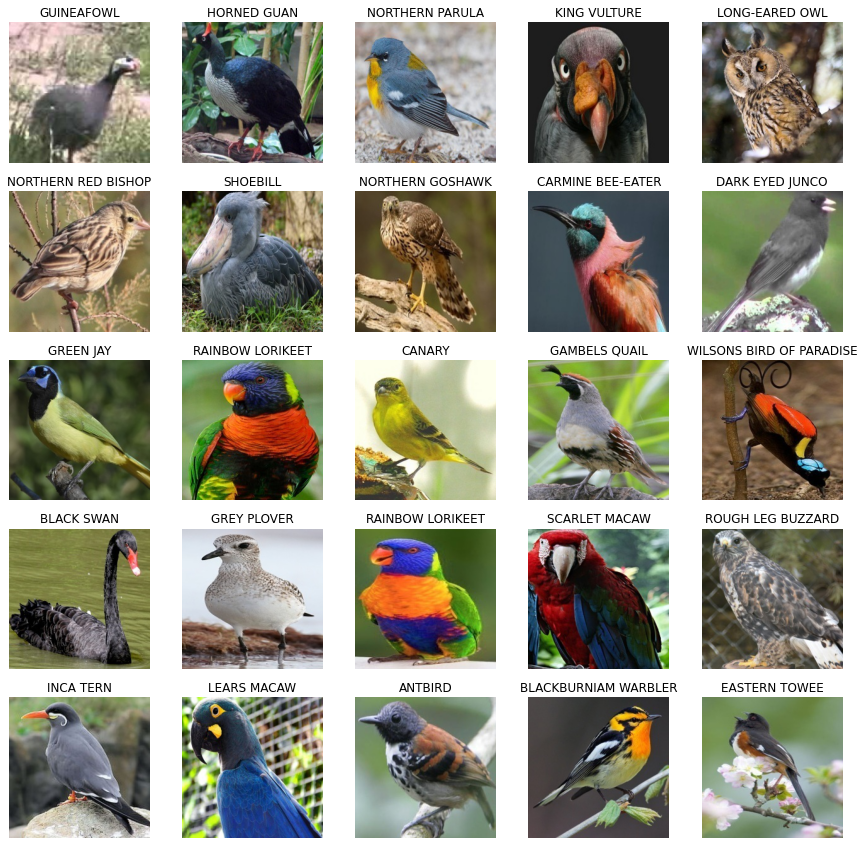

time: 2.3 s


In [17]:
import random
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import plotly.express as px
def display_random_grid(ncols=5, ds_path=consolidated_dir):
    fig, ax = plt.subplots(ncols=ncols, nrows=ncols, figsize=(15, 15))
    
    for i in range(ncols):
        for j in range(ncols):
            bird_species = random.choice(os.listdir(ds_path))
            random_bird_path = random.choice(os.listdir(ds_path + bird_species))
            random_bird = mpimg.imread(ds_path + bird_species + '/' + random_bird_path)
            ax[i, j].imshow(random_bird)
            ax[i, j].set_title(bird_species)
            ax[i, j].axis('off')
            
display_random_grid()

<font color="magenta"> Sri : Using ResNet101V2

In [18]:
from keras.applications import ResNet101V2
convlayer=ResNet101V2(input_shape=(224,224,3),weights='imagenet',include_top=False)
for layer in convlayer.layers:
    layer.trainable=False

171319296/171317808 [==============================] - 2s 0us/step
time: 11 s


<font color="magenta"> Sri : Building the model

Epoch 1/10
126/126 [==============================] - 167s 1s/step - loss: 2.1559 - accuracy: 0.5370 - val_loss: 0.3517 - val_accuracy: 0.8939
Epoch 2/10
126/126 [==============================] - 177s 1s/step - loss: 0.4246 - accuracy: 0.8982 - val_loss: 0.2345 - val_accuracy: 0.9383
Epoch 3/10
126/126 [==============================] - 181s 1s/step - loss: 0.1559 - accuracy: 0.9674 - val_loss: 0.1954 - val_accuracy: 0.9539
Epoch 4/10
126/126 [==============================] - 181s 1s/step - loss: 0.0724 - accuracy: 0.9869 - val_loss: 0.1918 - val_accuracy: 0.9513
Epoch 5/10
126/126 [==============================] - 181s 1s/step - loss: 0.0506 - accuracy: 0.9906 - val_loss: 0.1843 - val_accuracy: 0.9557
Epoch 6/10
126/126 [==============================] - 181s 1s/step - loss: 0.0366 - accuracy: 0.9926 - val_loss: 0.1948 - val_accuracy: 0.9565
Epoch 7/10
126/126 [==============================] - 181s 1s/step - loss: 0.0289 - accuracy: 0.9945 - val_loss: 0.1720 - val_accuracy: 0.9557

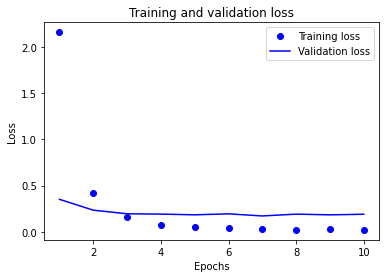

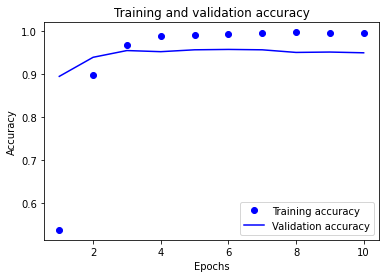

5/5 [==============================] - 5s 903ms/step - loss: 0.1259 - accuracy: 0.9678
test_acc: 0.9678260684013367
time: 30min 29s


In [19]:
backend.clear_session()
model = models.Sequential()
model.add(convlayer)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(2048,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(230,activation='softmax'))

opt=tf.keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])

history=model.fit(train_generator,validation_data=val_generator, epochs=10)

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(history_dict['accuracy']) + 1)

plt.plot(epochs, loss_values, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss_values, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, acc_values, 'bo', label = 'Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

test_loss, test_acc = model.evaluate(test_generator)
print('test_acc:', test_acc)

<font color="magenta"> Sri : Trying out Data Augmentation

Epoch 1/10
126/126 [==============================] - 171s 1s/step - loss: 2.1607 - accuracy: 0.5380 - val_loss: 0.3511 - val_accuracy: 0.8957
Epoch 2/10
126/126 [==============================] - 179s 1s/step - loss: 0.4228 - accuracy: 0.8995 - val_loss: 0.2404 - val_accuracy: 0.9383
Epoch 3/10
126/126 [==============================] - 181s 1s/step - loss: 0.1656 - accuracy: 0.9643 - val_loss: 0.2112 - val_accuracy: 0.9478
Epoch 4/10
126/126 [==============================] - 181s 1s/step - loss: 0.0785 - accuracy: 0.9840 - val_loss: 0.1772 - val_accuracy: 0.9530
Epoch 5/10
126/126 [==============================] - 181s 1s/step - loss: 0.0483 - accuracy: 0.9914 - val_loss: 0.1709 - val_accuracy: 0.9574
Epoch 6/10
126/126 [==============================] - 181s 1s/step - loss: 0.0314 - accuracy: 0.9948 - val_loss: 0.1776 - val_accuracy: 0.9530
Epoch 7/10
126/126 [==============================] - 181s 1s/step - loss: 0.0231 - accuracy: 0.9966 - val_loss: 0.1696 - val_accuracy: 0.9557

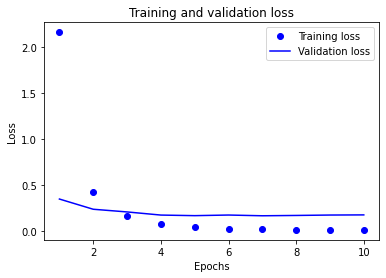

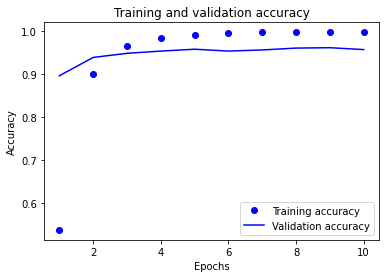

5/5 [==============================] - 5s 905ms/step - loss: 0.1071 - accuracy: 0.9730
test_acc: 0.9730435013771057
time: 30min 29s


In [21]:
backend.clear_session()
model_aug = models.Sequential()
model_aug.add(convlayer)
model_aug.add(Dropout(0.5))
model_aug.add(Flatten())
model_aug.add(BatchNormalization())
model_aug.add(Dense(2048,kernel_initializer='he_uniform'))
model_aug.add(BatchNormalization())
model_aug.add(Activation('relu'))
model_aug.add(Dropout(0.5))
model_aug.add(Dense(1024,kernel_initializer='he_uniform'))
model_aug.add(BatchNormalization())
model_aug.add(Activation('relu'))
model_aug.add(Dropout(0.5))
model_aug.add(Dense(230,activation='softmax'))

opt=tf.keras.optimizers.Adam(lr=0.001)
model_aug.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])

history=model_aug.fit(train_generator,validation_data=val_generator, epochs=10)

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(history_dict['accuracy']) + 1)

plt.plot(epochs, loss_values, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss_values, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, acc_values, 'bo', label = 'Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

test_loss, test_acc = model_aug.evaluate(test_generator)
print('test_acc:', test_acc)


<font color="magenta"> Sri : Slightly higher accuracy with data augmentation. The run time is the same as the model without data augmentation.